In [3]:
import os
import shutil
import re
import subprocess
import dicom2nifti
import SimpleITK as sitk
import numpy as np
import nibabel as nib
import ants
import time
#import gui # git clone https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks.git
import matplotlib.pyplot as plt
#import JupyterNotebooksLib as slicernb
#import slicer

#==========================================================================================================================================================
# CODE DESCRIPTION (WIP):

# 1) FILE PATHS ARE SUPPLIED FOR THE PARENT DIRECTORIES OF THE:
	# 1a) FRC FILES [/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done]
	# 1b) TLC FILES [\\lc-rs-store25.hpc.uiowa.edu\teamwork\public_resources\Scan_Exchange\for_Junfeng\SPIR--ATS-VessDys-TLCs\1-UseThis-Unzipped-APKs]
	# 1c) COMPLETED CASE DIRECTORIES [/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done]
# 2) CASE NUMBERS ('Case-##') & CASE PATHS ARE STORED IN SEPARATE LISTS DERIVED FROM THE COMPLETED CASE DIRECTORIES
# 3) CASES ARE LOOPED THROUGH FOR REGISTRATION PROCESSING:
	# 3a) A SUBDIRECTORY IS CREATED IN .......

#==========================================================================================================================================================

####################################################################################################################################
####################################################################################################################################

#*******************************
# TESTED FOR BASIC FUNCTIONALITY
#*******************************

# FUNCTION TO GET/STORE ALL OF THE CASE NUMBERS AND DIRECTORY PATHS USED WITH OTHER FUNCTIONS AND THE FINAL PRINT STATEMENT FOR EACH COMPLETED REGISTRATION

def get_case_nums(casePath):
    
    workDir = casePath
    caseNums = []
    caseDirs = []
    subString = 'Case-'
    for item in os.listdir(workDir):
        itemLower = item.lower()
        if(itemLower.startswith(subString.lower())):
            newCaseDir = os.path.join(workDir, item)
            caseDirs.append(newCaseDir)
            # CHECKS FOR 'Case-' + NUMBERS MATCH IN DIRECTORY NAME -> CASE INSENSITIVE
            match = re.match(r'(?i)Case-(\d+)', item)
            if match:
                caseN = "Case-" + match.group(1)
                caseNums.append(caseN)
    return caseNums, caseDirs

####################################################################################################################################
####################################################################################################################################

# CREATES OUTPUT DIRECTORY WITHIN SUBDIRECTORY NAMED AFTER CASE-##
# 'folder_path' STORES PATH TO OUTPUT DIRECTORY WHERE FILES ARE COPIED TO
# SUBDIRECTORY WILL BE MADE HERE TO STORE THE 'MOVING' FILE AFTER REGISTRATION

def create_case_folder(caseN, caseD):
    
    folder_name = caseN + "_registered"
    folder_path = os.path.join(caseD, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    #print("Case folder created...")
    return folder_path

####################################################################################################################################
####################################################################################################################################

#Not Functional with certain cases: Function finds and copies the FRC file to U-AllysonRegistration and Case ID. There is a lot of variability for what type of file is available for FRC for each case so pick the best optioon and manually copy to correct folder. 

# COPIES FRC FILE FROM SUPPLIED SOURCE DIRECTORY 'frcPath' TO 'folder_path' DIRECTORY, WHERE REGISTRATION WILL BE DONE

def load_FRC_find_CaseID(case_number, folder_path, frcPath):
    
    found_file = None
    case_id = None
    destination_folder = folder_path
    #source_folder = "z:/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done"
    source_folder = frcPath
    #destination_path = ''

    for root, dirs, files in os.walk(source_folder):
        for dir_name in dirs:
            dir_name_lower = dir_name.lower()
            if dir_name_lower.startswith(case_number.lower()):
                case_folder = os.path.join(root, dir_name)
                # SEARCH THOUGH THE MATCHING 'CASE-' SUBDIRECTORY
                for _ , subDirs, _ in os.walk(case_folder):
                    for subDir in subDirs:
                        # SETS A SUBSTRING TO FIND IN ONE OF THE SUBDIRECTORIES WITHIN THE MATCHING 'CASE-' DIRECTORY
                        frcSubStr = "Additional Image"
                        # CHECKS FOR LOWERCASE SUBSTRING MATCH
                        if frcSubStr.lower() in subDir.lower():
                            additional_images_folder = os.path.join(case_folder, subDir)
                            #print("Path to additional image directory:")
                            #print(os.path.join(case_folder, subDir))
                            if os.path.exists(additional_images_folder):
                                for root2, dirs2, files2 in os.walk(additional_images_folder):
                                    for file in files2:
                                        if "0.5" in file and "150KV" in file:
                                            found_file = os.path.join(root2, file)
                                            destination_path = os.path.join(destination_folder, os.path.basename(found_file))
                                            shutil.copy(found_file, destination_path)
                                            # Extract the Case ID from the file name
                                            case_id_match = re.search(r'(?<=SPI-)([^_]+)-PBV_SPIROMICS', found_file)
                                            case_id = case_id_match.group(1)
                                            #print(f"Case ID: {case_id}")
                                            break
    #print("FRC case id identified:")
    #print(case_id)
    print("FRC file found at [" + additional_images_folder + "]")
    return case_id, destination_path

####################################################################################################################################
####################################################################################################################################

#Not Working: Function finds the TLC folder in teamwork and copies to Case Folder. This had some sort of access/permission needed error so again this needs to be maunally copied over to the correct case folder. 

def load_TLC_folder(case_id, folder_path):
    
    found_file = None
    #source_folder = r"\\lc-rs-store25.hpc.uiowa.edu\teamwork\public_resources\Scan_Exchange\for_Junfeng\SPIR--ATS-VessDys-TLCs\1-UseThis-Unzipped-APKs" # EDIT THIS
    source_folder = folder_path
    destination_folder = folder_path
    destination_apk_path = ''

    for root, dirs, files in os.walk(source_folder):
        for dir in dirs:
            if case_id in dir:
                found_file = os.path.join(root, dir)
                destination_apk_path = os.path.join(destination_folder, found_file)
                shutil.copy(found_file, destination_apk_path)
    #print("TLC folder copied to case file successfully")
    print("TLC folder copied to [" + destination_apk_path + "]")

####################################################################################################################################
####################################################################################################################################

# LOADS TLC DICOM SERIES AND CONVERTS IT TO A '*.nii.gz' FILE IN THE 'folder_path' DIRECTORY

def load_TLC_DICOM(case_id, folder_path, tlcPath, caseN):

    source_folder = tlcPath
    subfolders = [f for f in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, f))]
    target_subfolder = None

    for subfolder in subfolders:
        if "TLC" in subfolder and str(case_id) in subfolder:
            target_subfolder = subfolder
            break

    if target_subfolder is None:
        print(f"Error: Subfolder with case id and 'TLC' not found.")
        return None

    target_subfolder_path = os.path.join(source_folder, target_subfolder)

    dicom_folder_path = None
    for root, dirs, files in os.walk(target_subfolder_path):
        if 'dicom' in dirs:
            dicom_folder_path = os.path.join(root, 'dicom')
            break

    nifti_output_path = folder_path
	
	# CONVERT TLC DICOMS TO .nii.gz FILES
    dicom2nifti.convert_directory(dicom_folder_path, nifti_output_path, compression=True, reorient=True)
    #print('TLC DICOM loaded successfully')
    print("TLC DICOM found at [" + dicom_folder_path + "] -> converted to .nii.gz")#, saved to [" + nifti_output_path + "]")

####################################################################################################################################
####################################################################################################################################

# RENAMES THE FRC AND TLC *.nii.gz FILES IN THE 'folder_path' DIRECTORY

def rename_files(case_id, folder_path):
    
    source_folder = folder_path
    frc_new_file_path = ''
    tlc_new_file_path = ''
    nameCheck = False
    frcRename = False
    tlcRename = False

    for filename in os.listdir(source_folder):

        # Check if the file name contains a certain case id
        if "SN150KV" in filename and case_id in filename and filename.endswith(".nii.gz"):
            new_filename = "FRC-DICOM.nii.gz"
            old_file_path = os.path.join(source_folder, filename)
            frc_new_file_path = os.path.join(source_folder, new_filename)

            if not os.path.exists(source_folder + "\\FRC-DICOM.nii.gz"):
                frcRename = True
                # Rename the file
                os.rename(old_file_path, frc_new_file_path)

        # Check if the file name contains "inspiration" and ends with .nii.gz
        elif "inspiration" in filename and filename.endswith(".nii.gz"):
            new_filename = "TLC-DICOM.nii.gz"
            old_file_path = os.path.join(source_folder, filename)
            tlc_new_file_path = os.path.join(source_folder, new_filename)

            if not os.path.exists(source_folder + "\\TLC-DICOM.nii.gz"):
                tlcRename = True
                # Rename the file
                os.rename(old_file_path, tlc_new_file_path)

        else:
            # Skip files that don't match the specified conditions
            continue

        if(os.path.exists(source_folder + "\\FRC-DICOM.nii.gz") and os.path.exists(source_folder + "\\TLC-DICOM.nii.gz")):
            
            if (nameCheck):
                continue
            nameCheck = True
            print("No file renaming required")

    if(frcRename):
        print('FRC file renamed')
    if(tlcRename):
        print('TLC file renamed')
        
    return frc_new_file_path,tlc_new_file_path

####################################################################################################################################
####################################################################################################################################

#export ITK_NIFTI_SFORM_PERMISSIVE=1

# RUNS AN ANTsPy REGISTRATION ON THE FRC & TLC FILES IN THE 'folder_path' DIRECTORY
# THE MOVING/WARPED FILE WILL BE EXPORTED TO A SUBDIR OF 'folder_path' -> 'outFolderPath'

def run_registration_antspy(folder_path):

	#======================================================================================================
	# NOTE: ANTsImage TYPES (EX below: movingImg) ACT BASICALLY AS A NUMPY ARRAY
	#EX: CLONING CONVERT TO NUMPY, NEW IMG WITH SAME PROPERTIES BUT NEW DATA, FILE SAVE,STATS, ETC
	#======================================================================================================

	# https://antspy.readthedocs.io/en/latest/registration.html#module-ants
    # https://antspy.readthedocs.io/en/latest/_modules/ants/registration/interface.html#registration

    startTime = time.time()

    print("Beginning ANTsPy registration...")

    source_folder = folder_path

	# CREATE OUTPUT DIRECTORY FOR REGISTRATION RESULTS
    outFolderPath = os.path.join(source_folder, "ANTsPy_Registration_Outputs")
    os.makedirs(outFolderPath, exist_ok=True)

    outMovingFileName2 = "WARPED_DATASET_warped_warpedmovout1_case22_float.nii.gz"

    # SETS THE OUTPUT DIRECTORY FOR THE REGISTERED IMAGE
    outputDir = os.path.join(source_folder, outFolderPath)
    outputFilePath2 = os.path.join(outputDir, outMovingFileName2)

	# SETS FILEPATHS
	# NOTE: MAY NEED TO AUTOMATE METHOD TO DECLARE FILE NAME + EXTENSION, OR USE REGEX TO GET THIS
    # NOTE 2: FRC = fixed, TLC = moving
    fixedImgPath = os.path.join(source_folder, "FRC-DICOM.nii.gz")
    movingImgPath = os.path.join(source_folder, "TLC-DICOM.nii.gz")
	
    print("Reading in datasets...")
    #print("Fixed dataset path: " + fixedImgPath)
    #print("Moving dataset path: " + movingImgPath)
	
	#------------------------------------------------------------------------------------------------------
	
    # TRY/EXCEPT IS USED TO CATCH FILES WITH HEADER ISSUES
    # FILES WITH HEADER ISSUES WILL HAVE THEIR NAMES LOGGED TO A TEXT FILE FOR MANUAL PROCESSING?
    # ALTERNATIVE: GET SlicerANTs MODULE WORKING FROM PYTHON CODE
    
    try:
        
        # READ IN FILES FROM FILEPATH VIA 'ANTS' FUNCTION
        # Supported types are 'float', 'double', 'unsigned int', 'unsigned char'
        fixedImg = ants.image_read(fixedImgPath, pixeltype="float", reorient=False)
        movingImg = ants.image_read(movingImgPath, pixeltype="float", reorient=False)

        # PRINTS PLOT OF CENTER AXIAL IMAGE BEFORE REGISTRATION - USED FOR COMPARISON (OPTIONAL)
        #fixedImg.plot(overlay=moving, title ='Before Registration')

        # REGISTERS A PAIR OF IMAGES THROUGH FULL OR SIMPLIFIED ANTs REG METHOD
        # 'Symmetric normalization' (SyN): Affine + deformable transformation, with mutual information as optimization metric

        print("Registering moving dataset using 'QuickRigid'...")
        
        transf = ants.registration(fixed=fixedImg, moving=movingImg, type_of_transform='QuickRigid') # BETTER REGISTRATION METHOD = "SyN"

        # 
        #warped_moving = transf['warpedmovout']

        # PRINTS PLOT OF IMAGES AFTER REGISTRATION
        #fixed.plot(overlay=warped_moving,vtitle='After Registration')
        
        # USE THE TRANSFORMS OUTPUT FROM REGISTRATION AND APPLY THEM DIRECTLY TO THE IMAGE
        # ***REVIEW THIS***
        warpedImage1 = ants.apply_transforms(fixedImg, movingImg, transformlist=transf['fwdtransforms'])
        ants.image_write(warpedImage1, outputFilePath2, ri=False)# USE THIS 
        
        endTime = time.time()

        # TIME IN SECONDS
        elapsedTimeS = endTime - startTime
        # TIME IN MINUTES
        elapsedTimeM = elapsedTimeS/60

        #------------------------------------------------------------------------------------------------------
        # PRINT PLOT OF 10 CHECKERBOARD IMAGES (FRC/TLC) EVENLY SPACED THROUGH THE DATASETS TO SHOW ACCURACY OF REGISTRATION
        # WIP
        # http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/05_Results_Visualization.html
        #gui.MultiImageDisplay(image_list = [sitk.CheckerBoard(img1, img2, [4,4,4]), sitk.CheckerBoard(img1_255, img2_255, (10,10,4))],
                        #title_list = ['original intensities', 'rescaled intensities'],
                        #figure_size=(9,3));
        #------------------------------------------------------------------------------------------------------
        
        # LOAD DATASETS TO GENERATE PLOT OF 10 CHECKERBOARD IMAGES
        # LOAD FIXED DATASET (FRC)
        image1 = nib.load(fixedImgPath).get_fdata()
        # LOAD WARPED TLC DATASET 
        image2 = nib.load(outputFilePath2).get_fdata()

        # ======================================================================
        # GENERATE PLOT OF 10 CHECKERBOARD IMAGES (CORONAL VIEW) 

        # Ensure that both images have the same shape
        if image1.shape != image2.shape:
            raise ValueError("Images must have the same shape")

        # Create a combined image with the same shape as the original images
        combined_image = np.zeros_like(image1)

        # Define the size of each checkerboard cube
        cube_size = 50

        # Iterate over the slices in the y-direction for coronal view
        for y in range(image1.shape[1]):
            # Determine whether the checkerboard pattern should start with image1 or image2
            start_with_image1 = ((y + cube_size // 2) // cube_size) % 2 == 0
            
            # Iterate over each voxel in the current slice
            for z in range(image1.shape[2]):
                for x in range(image1.shape[0]):
                    # Determine whether to use image1 or image2 at the current voxel
                    if (x // cube_size + z // cube_size) % 2 == 0:
                        if start_with_image1:
                            combined_image[x, y, z] = image1[x, y, z]
                        else:
                            combined_image[x, y, z] = image2[x, y, z]
                    else:
                        if start_with_image1:
                            combined_image[x, y, z] = image2[x, y, z]
                        else:
                            combined_image[x, y, z] = image1[x, y, z]

        # Sample 10 evenly spaced slices from the coronal orientation
        num_slices = combined_image.shape[1]
        sampled_slices = np.linspace(0, num_slices - 1, num=10, dtype=int)

        # Create a subplot for all 10 images
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))

        # Loop through the sampled slices and display each one
        for i, slice_idx in enumerate(sampled_slices):
            row_idx = i // 5
            col_idx = i % 5
            
            axes[row_idx, col_idx].imshow(combined_image[:, slice_idx, :], cmap='gray')
            axes[row_idx, col_idx].set_title(f'Slice {slice_idx}')

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

        # ======================================================================

        # WORKS -> PRINTS PLOT OF 10 CHECKERBOARD IMAGES (AXIAL VIEW)

        # # Ensure that both images have the same shape
        # if image1.shape != image2.shape:
        #     raise ValueError("Images must have the same shape")

        # # Create a combined image with the same shape as the original images
        # combined_image = np.zeros_like(image1)

        # # Define the size of each checkerboard cube
        # cube_size = 50

        # # Iterate over the slices in the z-direction
        # for z in range(image1.shape[2]):
        #     # Determine whether the checkerboard pattern should start with image1 or image2
        #     start_with_image1 = (z // cube_size) % 2 == 0
            
        #     # Iterate over each voxel in the current slice
        #     for y in range(image1.shape[1]):
        #         for x in range(image1.shape[0]):
        #             # Determine whether to use image1 or image2 at the current voxel
        #             if (x // cube_size + y // cube_size) % 2 == 0:
        #                 if start_with_image1:
        #                     combined_image[x, y, z] = image1[x, y, z]
        #                 else:
        #                     combined_image[x, y, z] = image2[x, y, z]
        #             else:
        #                 if start_with_image1:
        #                     combined_image[x, y, z] = image2[x, y, z]
        #                 else:
        #                     combined_image[x, y, z] = image1[x, y, z]

        # # Sample 10 evenly spaced slices from the axial orientation
        # num_slices = combined_image.shape[2]
        # sampled_slices = np.linspace(0, num_slices - 1, num=10, dtype=int)

        # # Create a subplot for all 10 images
        # fig, axes = plt.subplots(2, 5, figsize=(20, 8))

        # # Loop through the sampled slices and display each one
        # for i, slice_idx in enumerate(sampled_slices):
        #     row_idx = i // 5
        #     col_idx = i % 5
            
        #     axes[row_idx, col_idx].imshow(combined_image[:, :, slice_idx], cmap='gray')
        #     axes[row_idx, col_idx].set_title(f'Slice {slice_idx}')

        # # Adjust layout and display the plot
        # plt.tight_layout()
        # plt.show()

        # ======================================================================

        # WORKS - PRINTS PLOT OF 10 CHECKERBOARD IMAGES OVERLAY WITH ~50% TRANSPARENCY FOR EACH DATASET (AXIAL VIEW)

        # # Ensure that both images have the same shape
        # if image1.shape != image2.shape:
        #     raise ValueError("Images must have the same shape")

        # # Sample 10 evenly spaced slices from the axial orientation
        # num_slices = image1.shape[2]
        # sampled_slices = np.linspace(0, num_slices - 1, num=10, dtype=int)

        # # Create a subplot for all 10 images
        # fig, axes = plt.subplots(2, 5, figsize=(20, 8))

        # # Loop through the sampled slices and display each one
        # for i, slice_idx in enumerate(sampled_slices):
        #     row_idx = i // 5
        #     col_idx = i % 5
            
        #     # Create a checkerboard pattern for the current slice
        #     checkerboard = np.indices(image1[:, :, slice_idx].shape).sum(axis=0) % 2
            
        #     # Create the combined image for the current slice
        #     combined_slice = np.where(checkerboard == 0, image1[:, :, slice_idx], image2[:, :, slice_idx])
            
        #     axes[row_idx, col_idx].imshow(combined_slice, cmap='gray')
        #     axes[row_idx, col_idx].set_title(f'Slice {slice_idx}')

        # # Adjust layout and display the plot
        # plt.tight_layout()
        # plt.show()

    except:

        match = re.match(r'(?i)Case-(\d+)', fixedImgPath)
        print("\n" + "*" * 20 +"\n-> Error encountered with " + match + ".\n Relevent files located at:\nFRC: [" + fixedImgPath + "]\nTLC: [" + movingImgPath + "]\nSkipping to next case...\n" + "*" * 20)

    # TRY TO GET slicerANTs WORKING FOR FILES WITH HEADER ISSUES?
	
    return outputFilePath2,elapsedTimeS,elapsedTimeM

####################################################################################################################################	
####################################################################################################################################

def run_registration_elastix(folder_path, paramFileElastix, elastixFilePath):
    
    startTime = time.time()

    print("Beginning elastix registration...")
    outputFilePath2 = folder_path
    paramFileE = paramFileElastix
    elastixPath = elastixFilePath

    # Path to fixed and moving images
    fixed_image = os.path.join(outputFilePath2, "FRC-DICOM.nii.gz")
    moving_image = os.path.join(outputFilePath2, "TLC-DICOM.nii.gz")

    # Path to output folder
    outFolderPath = os.path.join(outputFilePath2, "Elastix_Registration_Outputs")
    os.makedirs(outFolderPath, exist_ok=True)

    # Output directory for the registered image
    output_directory = os.path.join(outputFilePath2, outFolderPath)

    try:
        # Run Elastix registration
        registration_command = [elastixPath, "-f", fixed_image, "-m", moving_image, "-out", output_directory, "-p", paramFileE]#, "-p", parameter_file3]
        subprocess.run(registration_command)
        print("Registration complete")

        endTime = time.time()

        # TIME IN SECONDS
        elapsedTimeS = endTime - startTime
        # TIME IN MINUTES
        elapsedTimeM = elapsedTimeS/60

        #--------------------------------------------------------
        # GENERATE PLOT OF 10 CHECKERBOARD IMAGES (CORONAL VIEW) 

        fixedImgPath = os.path.join(outputFilePath2, "FRC-DICOM.nii.gz")
        movingImgPath = os.path.join(output_directory, "result.0.nii") # LOADS ELASTIX WARPED FILE AS MOVING IMAGE

        image1 = nib.load(fixedImgPath).get_fdata()
        # LOAD WARPED TLC DATASET 
        image2 = nib.load(movingImgPath).get_fdata()

        # Ensure that both images have the same shape
        if image1.shape != image2.shape:
            raise ValueError("Images must have the same shape")

        # Create a combined image with the same shape as the original images
        combined_image = np.zeros_like(image1)

        # Define the size of each checkerboard cube
        cube_size = 50

        # Iterate over the slices in the y-direction for coronal view
        for y in range(image1.shape[1]):
            # Determine whether the checkerboard pattern should start with image1 or image2
            start_with_image1 = ((y + cube_size // 2) // cube_size) % 2 == 0
            
            # Iterate over each voxel in the current slice
            for z in range(image1.shape[2]):
                for x in range(image1.shape[0]):
                    # Determine whether to use image1 or image2 at the current voxel
                    if (x // cube_size + z // cube_size) % 2 == 0:
                        if start_with_image1:
                            combined_image[x, y, z] = image1[x, y, z]
                        else:
                            combined_image[x, y, z] = image2[x, y, z]
                    else:
                        if start_with_image1:
                            combined_image[x, y, z] = image2[x, y, z]
                        else:
                            combined_image[x, y, z] = image1[x, y, z]

        # Sample 10 evenly spaced slices from the coronal orientation
        num_slices = combined_image.shape[1]
        sampled_slices = np.linspace(0, num_slices - 1, num=10, dtype=int)

        # Create a subplot for all 10 images
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))

        # Loop through the sampled slices and display each one
        for i, slice_idx in enumerate(sampled_slices):
            row_idx = i // 5
            col_idx = i % 5
            
            axes[row_idx, col_idx].imshow(combined_image[:, slice_idx, :], cmap='gray')
            axes[row_idx, col_idx].set_title(f'Slice {slice_idx}')

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()
        elastixUsed = True
    #--------------------------------------------------------

    except:
        match = re.match(r'(?i)Case-(\d+)', fixedImgPath)
        print("\n" + "*" * 20 +"\n-> Error encountered with " + match + ".\n Relevent files located at:\nFRC: [" + fixedImgPath + "]\nTLC: [" + movingImgPath + "]\nSkipping to next case...\n" + "*" * 20)

    return outputFilePath2,elastixUsed,elapsedTimeS,elapsedTimeM


########################################
Case-22

FRC file found at [C:\Users\Adam\Downloads\registration_code\FILES\frc\case-22-Spiromics-53062428\Additional Images]
TLC DICOM found at [C:\Users\Adam\Downloads\registration_code\FILES\tlc\H-14479_JH110088_SPI-JH110088-V2_TLC_0.75_B35f_23390683\dicom] -> converted to .nii.gz
No file renaming required
Beginning elastix registration...
Registration complete


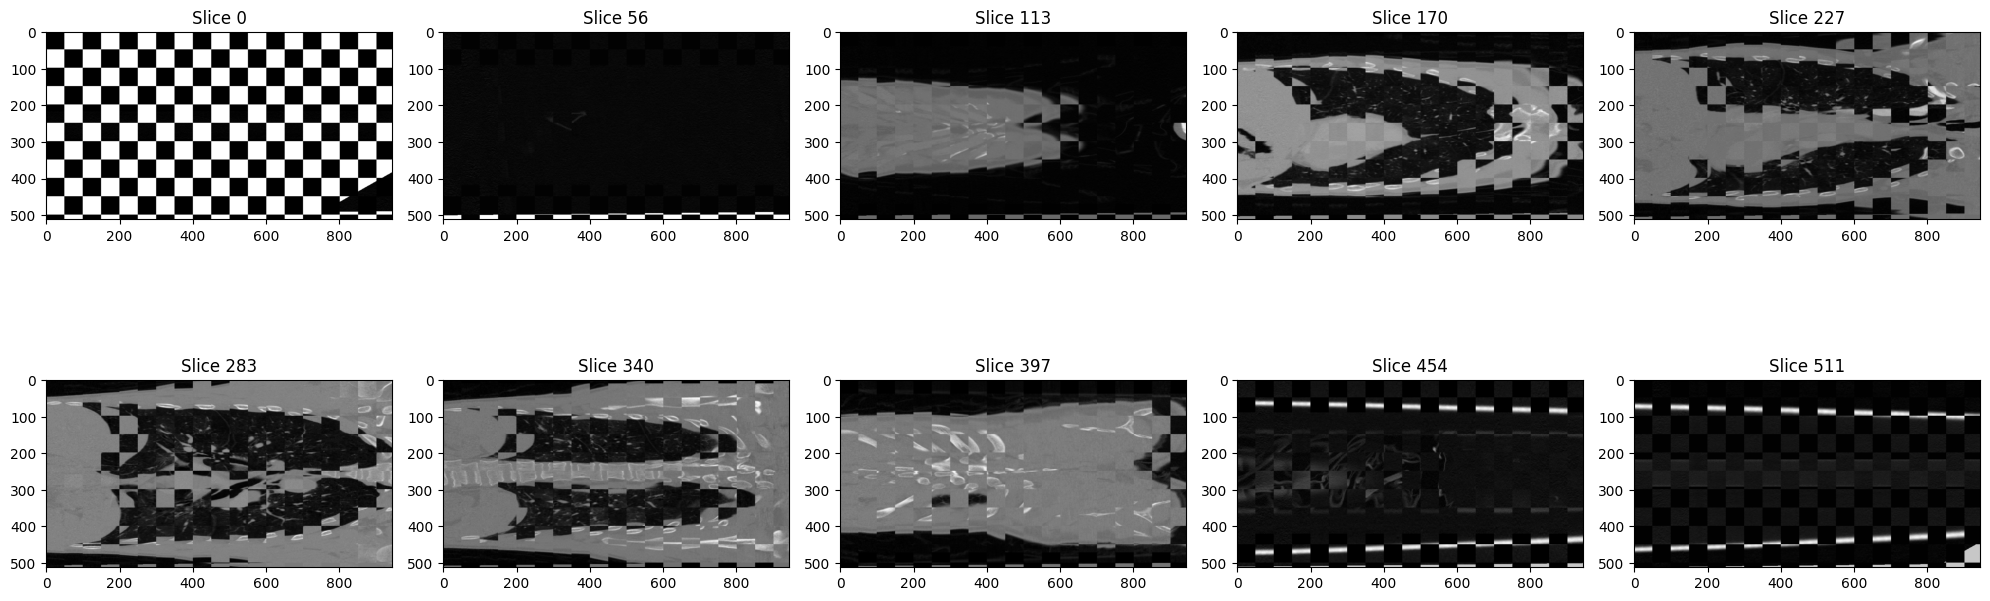

Case-22: 
FRC path: [C:\Users\Adam\Downloads\registration_code\FILES\case-22-Spiromics-53062428\Case-22_registered\FRC-DICOM.nii.gz] 
TLC path: [C:\Users\Adam\Downloads\registration_code\FILES\case-22-Spiromics-53062428\Case-22_registered\TLC-DICOM.nii.gz] 
Warped file path: [C:\Users\Adam\Downloads\registration_code\FILES\case-22-Spiromics-53062428\Case-22_registered] 
Elastix Registration completed in 311.226 seconds (5.187 minutes)
----------------------------------------
########################################
Case-24

FRC file found at [C:\Users\Adam\Downloads\registration_code\FILES\frc\Case-24-Spiromics-51287502\Additional Images]
TLC DICOM found at [C:\Users\Adam\Downloads\registration_code\FILES\tlc\H-14519_JH110704_SPI-JH110704-V2_TLC_0.75_B35f_27153060\H-14519_JH110704_SPI-JH110704-V2_TLC_0.75_B35f_27153060\dicom] -> converted to .nii.gz
No file renaming required
Beginning elastix registration...
Registration complete


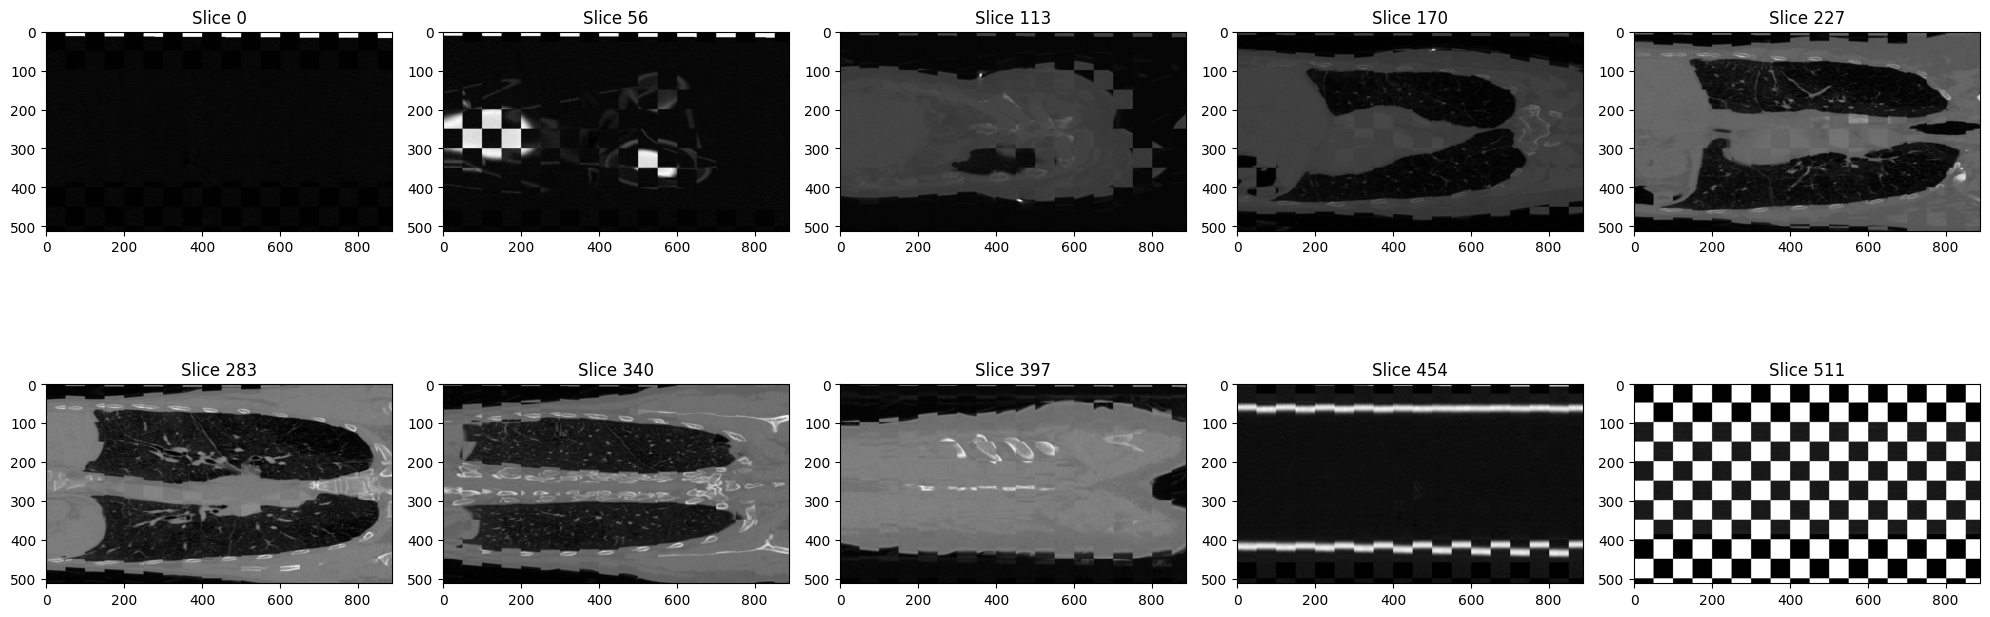

Case-24: 
FRC path: [C:\Users\Adam\Downloads\registration_code\FILES\CaSe-24-Spiromics-51287502\Case-24_registered\FRC-DICOM.nii.gz] 
TLC path: [C:\Users\Adam\Downloads\registration_code\FILES\CaSe-24-Spiromics-51287502\Case-24_registered\TLC-DICOM.nii.gz] 
Warped file path: [C:\Users\Adam\Downloads\registration_code\FILES\CaSe-24-Spiromics-51287502\Case-24_registered] 
Elastix Registration completed in 177.503 seconds (2.958 minutes)
----------------------------------------


All case registrations complete

Total runtime: 1277.615 seconds (21.294 minutes)
Total registration runtime only: 488.728seconds (8.145 minutes)


In [4]:
# FUNCTION CALLS
#===============

#---------------------------------------------
# FILE PATHS USED

# PATH TO ELASTIX EXECUTABLE
elastixFilePath = "C:\\Users\\Adam\\Downloads\\elastix\\elastix-5.1.0-win64\\elastix.exe"

# PATH TO ELASTIX PARAMETER FILE
paramFileElastix = "C:\\Users\\Adam\\Downloads\\elastix\\parameters\\Allyson\\Parameters_Rigid.txt"
#paramFileElastix = r"C:\Users\Adam\Downloads\elastix\parameters\Allyson\Parameters_BSpline.txt"
#paramFileElastix = r"C:\Users\Adam\Downloads\elastix\parameters\Allyson\Parameters.Par0008.affine.txt"
#paramFileElastix = r"C:\Users\Adam\Downloads\elastix\parameters\Allyson\Parameters.Par0008.elastic.txt"

# PATHS TO CASES DIRECTORY, FRC/TLC DIRECTORIES
#casePath = r"C:\Users\Adam\Downloads\registration_code\FILES"
casePath = "C:\\Users\\Adam\\Downloads\\registration_code\\FILES"
#frcPath = r"C:\Users\Adam\Downloads\registration_code\FILES\frc"
frcPath = "C:\\Users\\Adam\\Downloads\\registration_code\\FILES\\frc"
#frcPath = r"z:/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done"
#tlcPath = r"C:\Users\Adam\Downloads\registration_code\FILES\tlc"
tlcPath = "C:\\Users\\Adam\\Downloads\\registration_code\\FILES\\tlc"
#tlcPath = r"\\lc-rs-store25.hpc.uiowa.edu\teamwork\public_resources\Scan_Exchange\for_Junfeng\SPIR--ATS-VessDys-TLCs\1-UseThis-Unzipped-APKs"

#---------------------------------------------

startTime = time.time()

caseNums = []

# GET CASE NUMBERS & CASE DIRECTORY PATHS
caseNums, caseDirs = get_case_nums(casePath)

#print("Cases found at " + casePath)
#print(caseNums)
#print(caseDirs)

outputFilePath2 = ''
elastixUsed = False
regisrationTimeS = 0

# CREATE 'FOR' LOOP TO ITERATE THROUGH THE LIST OF CASES TO GET THEIR MATCHING FRC/TLC FILES AND REGISTER EACH HERE
for caseN, caseD in zip(caseNums, caseDirs):
	print('#' * 40)
	print(caseN + "\n")
	# NOTE: REVIEW THESE FUNCTIONS
	folder_path = create_case_folder(caseN, caseD)
	case_id,frcFile = load_FRC_find_CaseID(caseN, folder_path, frcPath)
	load_TLC_DICOM(case_id, folder_path, tlcPath, caseN)
	frc_new_file_path,tlc_new_file_path = rename_files(case_id, folder_path)
	
	#---------------------------------------------
	# REGISTRATION FUNCTION & REGISTRATION TIME ELAPSE

	# PERFORM TLC REGISTRATION TO FRC FILE, RETURN PATH TO WARPED FILE USING ANTsPy
	#outputFilePath2,elapsedTimeS,elapsedTimeM = run_registration_antspy(folder_path)

	# PERFORM TLC REGISTRATION TO FRC FILE, RETURN PATH TO WARPED FILE USING ELASTIX
	outputFilePath2,elastixUsed,elapsedTimeS,elapsedTimeM = run_registration_elastix(folder_path, paramFileElastix, elastixFilePath)

	regisrationTimeS += elapsedTimeS

	if elastixUsed:
		print(caseN + ": \nFRC path: [" + frc_new_file_path + "] \nTLC path: [" + tlc_new_file_path + "] \nWarped file path: [" + outputFilePath2 + "] \nElastix Registration completed in " + str(round(elapsedTimeS,3)) + " seconds (" + str(round(elapsedTimeM,3)) + " minutes)\n" + "-" * 40)
	else:
		print(caseN + ": \nFRC path: [" + frc_new_file_path + "] \nTLC path: [" + tlc_new_file_path + "] \nWarped file path: [" + outputFilePath2 + "] \nAntsPy Registration completed in " + str(round(elapsedTimeS,3)) + " seconds (" + str(round(elapsedTimeM,3)) + " minutes)\n" + "-" * 40)

	#---------------------------------------------
	
stopTime = time.time()

# TIME IN SECONDS
totalTimeS = stopTime - startTime
# TIME IN MINUTES
totalTimeM = totalTimeS/60
# TOTAL REGISTRATION TIME IN MINUTES
regisrationTimeM = regisrationTimeS/60

print("\n\nAll case registrations complete\n\nTotal runtime: " + str(round(totalTimeS, 3)) + " seconds (" + str(round(totalTimeM, 3)) + " minutes)")
print("Total runtime (registration only): " + str(round(regisrationTimeS, 3)) + " seconds (" + str(round(regisrationTimeM, 3)) + " minutes)")
